In [ ]:
# To update
!python -m pip uninstall -q tidy3d --yes
!pip install -q -e .
import os
os._exit(00)
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 600 * nm

# desired numerical aperture
NA = 0.5

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
W = 85 * nm
L = 410 * nm
H = 600 * nm
S = 430 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = 100 * nm

# side length of entire metalens (um)
side_length = 10

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / S)
print(f'for diameter of {side_length:.1f} um, have {N} cells per side')
print(f'full metalens has area of {side_length**2:.1f} um^2 and {N*N} total cells')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

for diameter of 10.0 um, have 23 cells per side
full metalens has area of 100.0 um^2 and 529 total cells


In [3]:
# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S

# focal length given diameter and numerical aperture
f = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# Function describing the theoretical best angle of each box at position (x,y).  see paper for details
def theta(x, y):
    return np.pi / wavelength * (f - np.sqrt(x ** 2 + y ** 2 + f ** 2))

# total domain size in z: (space -> substrate -> unit cell -> 1.7 focal lengths)
length_z = space_below_sub + thickness_sub + H + 1.7 * f

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[td.inf, td.inf, thickness_sub],
    ),
    medium=SiO2
)

# define coordinates of each unit cell
centers_x = S * np.arange(N) - length_xy / 2.0 + S / 2.0
centers_y = S * np.arange(N) - length_xy / 2.0 + S / 2.0
center_z = -length_z/2 + space_below_sub + thickness_sub + H / 2.0

# x, y vertices of box of size (L, W) centered at the origin
vertices_origin = np.array([[+L/2, +W/2],
                            [-L/2, +W/2],
                            [-L/2, -W/2],
                            [+L/2, -W/2]])


xs, ys = np.meshgrid(centers_x, centers_y, indexing='ij')
xs = xs.flatten()
ys = ys.flatten()

angles = theta(xs, ys)

# 2x2 rotation matrix angle `angle` with respect to x axis
rotation_matrix = np.array([
    [+np.cos(angles), -np.sin(angles)],
    [+np.sin(angles), +np.cos(angles)]
])

# rotate the origin vertices by this angle
vertices_rotated = np.einsum('ij, jkn -> nik', vertices_origin, rotation_matrix)

# shift the rotated vertices to be centered at (xs, ys)
vertices_shifted = vertices_rotated + np.stack([xs, ys], axis=-1)[:, None, :]

metalens_geometry = []
for vertices in vertices_shifted:
    # create a tidy3D PolySlab with these rotated and shifted vertices and thickness `H`
    metalens_geometry.append(
        td.PolySlab(
            vertices=vertices.tolist(),
            slab_bounds=(center_z-H/2, center_z+H/2),
            axis=2,
        ),
    )

metalens = td.Structure(
    geometry=td.GeometryGroup(geometries=metalens_geometry),
    medium=TiO2
)


In [5]:
# steps per unit cell along x and y
grids_per_unit_length = 20
# uniform mesh in x and y
grid_x = td.UniformGrid(dl=S / grids_per_unit_length)
grid_y = td.UniformGrid(dl=S / grids_per_unit_length)
# in z, use an automatic nonuniform mesh with the wavelength being the "unit length"
grid_z = td.AutoGrid(min_steps_per_wvl=grids_per_unit_length)
# we need to supply the wavelength because of the automatic mesh in z
grid_spec = td.GridSpec(wavelength=wavelength, grid_x=grid_x, grid_y=grid_y, grid_z=grid_z)
# put an override box over the pillars to avoid parsing a large amount of structures in the mesher
grid_spec = grid_spec.copy(update=dict(override_structures = [
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -length_z/2 + space_below_sub),
            rmax=(td.inf, td.inf, center_z + H/2)
        ),
        medium=TiO2,
    )
]))

In [6]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0,0,-length_z/2 + space_below_sub / 10.0),
    direction='+',
    pol_angle=0)

run_time = 50 / fwidth

In [7]:
# To decrease the amount of data stored, only store the E field in 2D monitors
fields = ["Ex", "Ey", "Ez"]

# get fields along x=y=0 axis
monitor_center = td.FieldMonitor(
    center=[0., 0., 0],
    size=[0, 0, td.inf],
    freqs=[f0],
    name='center'
)

# get the fields at a few cross-sectional planes
monitor_xz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[td.inf, 0., td.inf],
    freqs=[f0],
    name='xz',
    fields=fields,
)

monitor_yz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[0., td.inf, td.inf],
    freqs=[f0],
    name='yz',
    fields=fields,
)

monitor_xy = td.FieldMonitor(
    center=[0., 0., center_z + H/2 + f],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='focal_plane',
    fields=fields,
)

# put them into a single list
monitors=[monitor_center, monitor_xz, monitor_yz, monitor_xy]

In [8]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, metalens],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(),
        y=td.Boundary.absorber(),
        z=td.Boundary.pml()
    )
)

[12:06:00] WARNING: Override structures take no effect along x-axis. If intending to apply         ]8;id=346862;file:///home/hirako/tidy3d_dev/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=735070;file:///home/hirako/tidy3d_dev/tidy3d/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           override structures to this axis, use 'AutoGrid'.                                                       

           WARNING: Override structures take no effect along y-axis. If intending to apply         ]8;id=650119;file:///home/hirako/tidy3d_dev/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=351071;file:///home/hirako/tidy3d_dev/tidy3d/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           override structures to this axis, use 'AutoGrid'.                                                       

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


/home/hirako/anaconda3/envs/tidy3d_dev/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


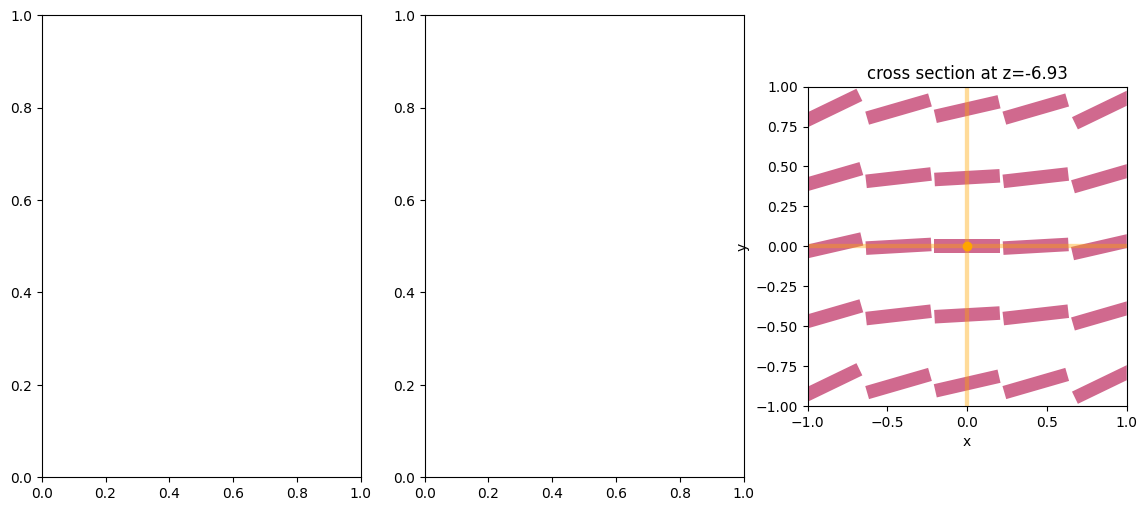

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
%time
# Time the visualization of the 2D plane
#sim.plot(x=0.1, hlim=[-4,4], ax=ax1);
#sim.plot(y=0.1, vlim=[-8,-6], ax=ax2);
sim.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, hlim=[-1,1], vlim=[-1,1], ax=ax3);

In [1]:
import time
lims = [[None,None],
        [[-5,5],[-5,5]],
        [[-4,4],[-4,4]],
        [[-3,3],[-3,3]],
        [[-2,2],[-2,2]],
        [[-1,1],[-1,1]],
       [[-0.5,0.5],[-0.5,0.5]]]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for l in lims:
    start_time = time.time()
    sim.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, hlim=l[0], vlim=l[1], ax=ax3);
    time_to_plot = time.time() - start_time
    print(l[0],l[1], time_to_plot)


NameError: name 'plt' is not defined

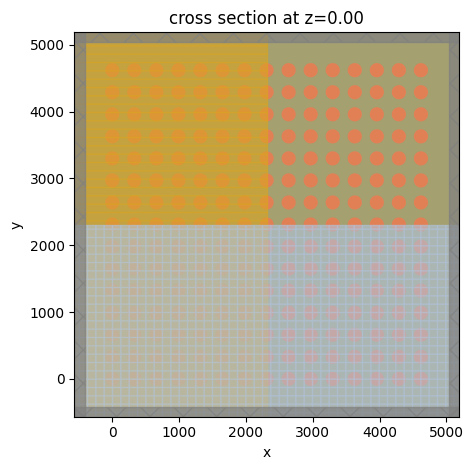

In [18]:
Nx = 15  # number of unit cells in the x direction
Ny = 15  # number of unit cells in the y direction
buffer = 0.5 * lda0  # buffer spacing in the x and y directions

# simulation domain size
Lx, Ly, Lz = Nx * p + 2 * buffer, Ny * p + 2 * buffer, 2 * lda0
sim_size = [Lx, Ly, Lz]

# systematicall construct the silicon resonators
metasurface = [substrate]
for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(
                center=[i * p, j * p, h / 2], radius=r, length=h, axis=2
            ),
            medium=Si,
        )
        metasurface.append(cylinder)

# define a gaussian beam with a waist radius of 3 wavelengths (focused beam)
gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    center=(p * (Nx // 2), p * (Ny // 2), 0.3 * lda0),
    direction="-",
    waist_radius=3 * lda0,
)

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

sim = td.Simulation(
    size=sim_size,
    center=(p * (Nx // 2), p * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=metasurface,
    sources=[gaussian],
    monitors=[
        monitor_t,
        monitor_r,
        monitor_field,
    ],  # we will reuse the flux monitors defined earlier
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    symmetry=(-1, 1, 0),
)  # the same symmetry can be used

sim.plot(z=0)
plt.show()

None None 2.140744209289551
[0, 5000] [0, 5000] 1.8343701362609863
[0, 4000] [0, 4000] 1.3933024406433105
[0, 3000] [0, 3000] 0.7728583812713623
[0, 2000] [0, 2000] 0.38432812690734863
[0, 1000] [0, 1000] 0.13604021072387695
[0, 500] [0, 500] 0.06307435035705566


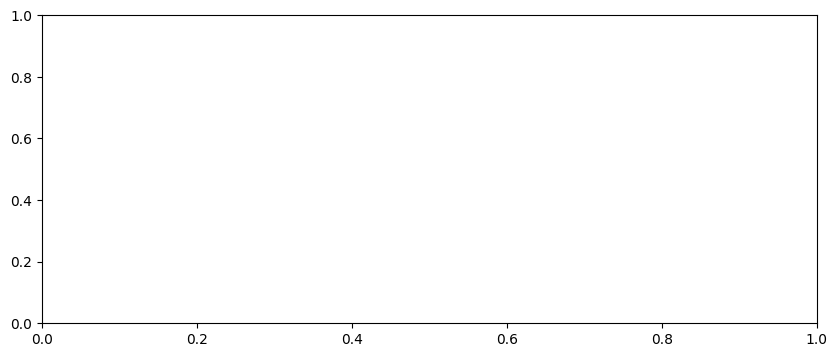

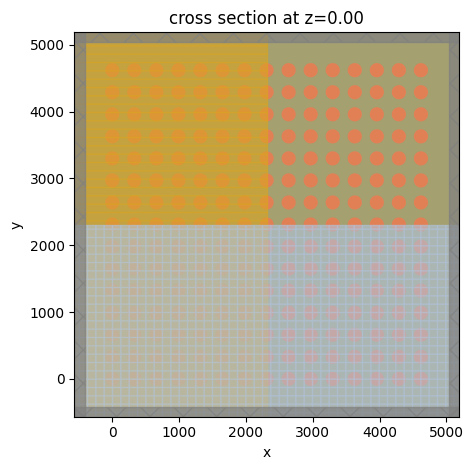

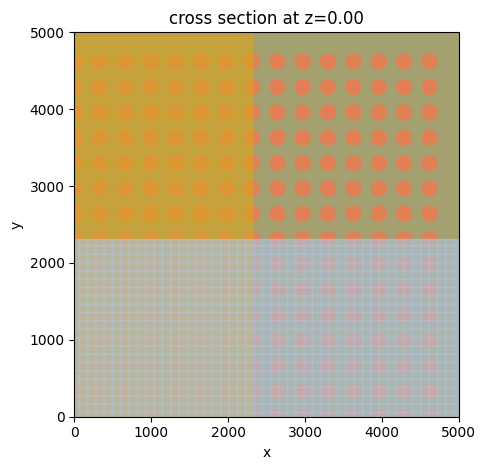

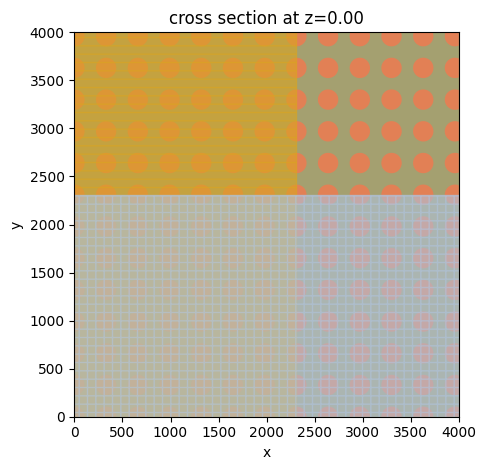

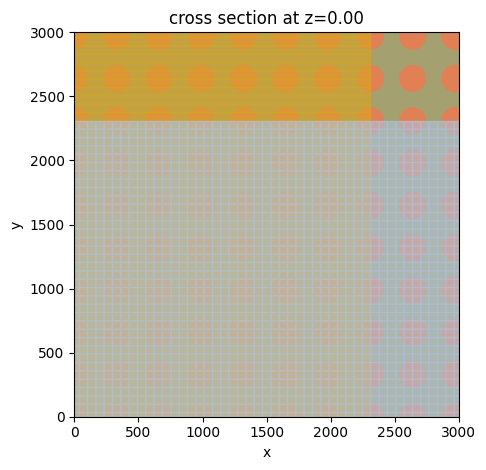

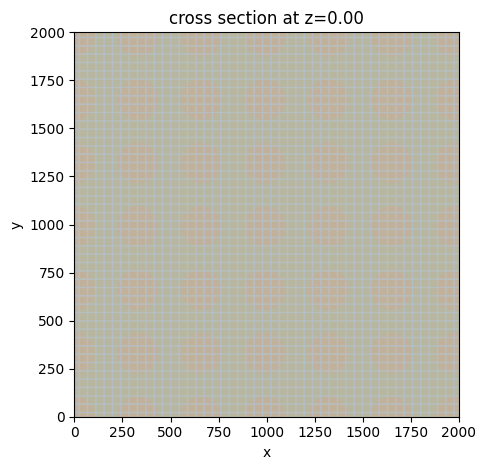

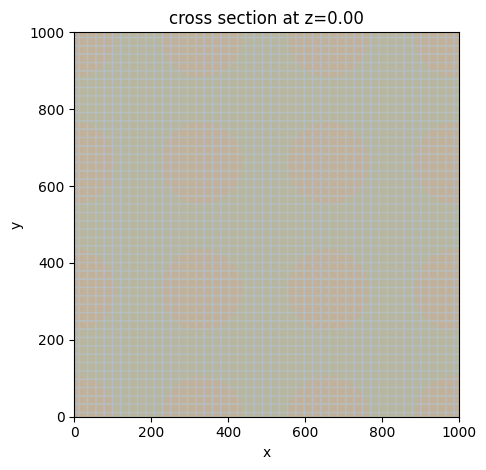

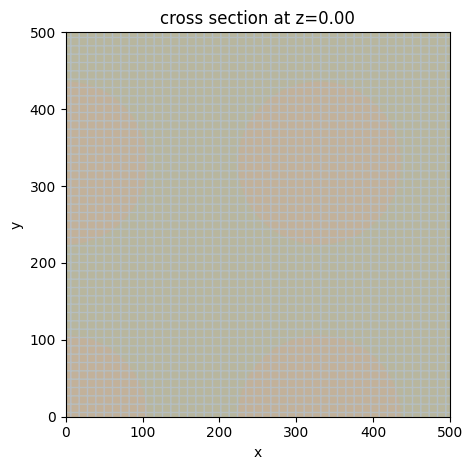

In [20]:
import time
lims = [[None,None],
        [[0,5000],[0,5000]],
        [[0,4000],[0,4000]],
        [[0,3000],[0,3000]],
        [[0,2000],[0,2000]],
        [[0,1000],[0,1000]],
        [[0,500],[0,500]]]

ts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for l in lims:
    start_time = time.time()
    sim.plot(z=0, hlim=l[0], vlim=l[1]);
    time_to_plot = time.time() - start_time
    print(l[0],l[1], time_to_plot)
    ts.append(time_to_plot)